In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [156]:
def initial_state():
            '''
            # random 10x10 grid
            # Each square has 1/2 probability to contain a can '1'
            # Robby is placed in a random square
            '''
            grid = np.random.binomial(1, p=.5, size=(10,10))
            return (grid)

def max_Q(sensors, Q_Matrix, robby):
    best_Q = 0
    for i,a in enumerate(sensors):
        key = tuple(robby) + tuple(a)
        if(key in Q_Matrix):
            Q = Q_Matrix[key]
            if(Q > best_Q):
                best_Q = Q
                action = a
    if(best_Q == 0):
        action = 'N'

    return (action)

def epsilon_greedy(epsilon, sensors, grid, robby, Q_Matrix):

    a =['C', 'N', 'E', 'S', 'W']
    prob_random = epsilon * 1000
    chance = np.random.randint(0, 1000) # Inclusive to exclusive

    # With probability (1 − ε)  choose action that maximizes current Q(s,a)
    if(chance >=prob_random or (epsilon == 0)): # max Action
        action = max_Q(sensors, Q_Matrix, robby)

    # With probability ε choose random action
    if(chance < prob_random and (epsilon != 0)): # random action
        chance = np.random.randint(0, 5) 
        action = str(a[chance])

    return(action)

def possible_actions(grid, robby):

    # 0 = empty, 1 = can, 2 = wall
    sensors = {}
    x = robby[0]
    y = robby[1]
    score = grid[x, y]
    
    if(score == 1):
        sensors['C'] = 1
    if(score != 1):
        sensors['C'] = 0

    # Move-North
    North = [x,y+1]
    if(North[1] == 10):
        sensors['N'] = 2
    if(North[1] != 10):
        if(grid[North[0], North[1]] == 1):
            sensors['N'] = 1
        if(grid[North[0], North[1]] == 0):
            sensors['N'] = 0

    # Move-East
    East = [x+1,y]
    if(East[0] == 10):
        sensors['E'] = 2
    if(East[0] != 10):
        if(grid[East[0], East[1]] == 1):
            sensors['E'] = 1
        if(grid[East[0], East[1]] == 0):
            sensors['E'] = 0

    # Move-South
    South = [x,y-1]
    if(South[1] == -1):
        sensors['S'] = 2
    if(South[1] != -1):
        if(grid[South[0], South[1]] == 1):
            sensors['S'] = 1
        if(grid[South[0], South[1]] == 0):
            sensors['S'] = 0
        
    # Move-West
    West = [x-1,y]
    if(West[0] == -1):
        sensors['W'] = 2
    if(West[0] != -1):
        if(grid[West[0], West[1]] == 1):
            sensors['W'] = 1
        if(grid[West[0], West[1]] == 0):
            sensors['W'] = 0
    return(sensors)


def next_state(action, grid, current):

    x = current[0]
    y = current[1]
    if(action == 'C'):
        return(current)
    if(action == 'N'):
        return [x,y+1]
    if(action == 'E'):
        return [x+1,y]
    if(action == 'S'):
        return [x,y-1]
    if(action == 'W'):
        return [x-1,y]

def next_state_and_reward(a_t, sensors, grid, current):

    # 0 = empty, 1 = can, 2 = wall
    if(sensors[a_t] == 0):
        S_t_next = next_state(a_t, grid, current)
        reward = 0
        if(a_t == 'C'): # If we chose current and there was no can
            reward = -1

    if(sensors[a_t] == 1): # If we chose a square holding a can
        S_t_next = next_state(a_t, grid, current)
        grid[current]= 0
        reward = 10

    if(sensors[a_t] == 2): # If we ran into a wall
        S_t_next = current
        reward = -5

    return (S_t_next, reward, grid)

def Q_Learning_Robby(N, M, epsilon, eta, gamma, training, Q_Matrix):

    total_reward = np.zeros((N,1))
    for episode in range(N):
        if (((episode+1) % 50) == 0 and(epsilon != 0) and training == True): # Every 50 Epoch's decrease epsilon
            epsilon = epsilon - 0.01
        grid = initial_state()
        # print(f"Starting Grid: \n{pd.DataFrame(grid)}")
        current_state = [np.random.choice(np.arange(10)), np.random.choice(np.arange(10))] # generate new state for robby
        for action in range(M):
            sensors = possible_actions(grid, current_state)
            a_t = epsilon_greedy(epsilon, sensors, grid, current_state, Q_Matrix) # Choose an action

            # Current Q score and state
            key = tuple(current_state) + tuple(a_t)
            if(key in Q_Matrix):
                current_Q = Q_Matrix[key]
            if(key not in Q_Matrix):
                current_Q = 0
                Q_Matrix[key] = 0

            S_t_next, reward, grid = next_state_and_reward(a_t, sensors, grid, current_state)
            total_reward[episode]=  total_reward[episode] + reward

            sensors2 = possible_actions(grid, S_t_next)
            a_t_next = epsilon_greedy(epsilon, sensors2, grid, S_t_next, Q_Matrix) # Choose an action

            # Next Q score and state
            key2 = tuple(S_t_next) + tuple(a_t_next)
            if(key2 in Q_Matrix): 
                next_Q = Q_Matrix[key2]
            if(key2 not in Q_Matrix):
                next_Q = 0
            
            update_Q = current_Q + (eta * (reward + (gamma * next_Q) - current_Q) )

            Q_Matrix[key] = update_Q # Update the current (state, action) with the updated score

            current_state = S_t_next # Update the new current state

            if(np.all(grid==0)):
                # print(f"All cans picked up in: {episode} Episodes")
                break

    # print(f"Ending Grid: \n{pd.DataFrame(grid)}")
    return (total_reward, Q_Matrix)

# ex. test N = 5,000 ; M = 200 ; 𝜂= 0.2; 𝛾= 0.9
N = 5000 # Number of Episodes
M = 200 # number of actions to perform in each episode
epsilon = 0.1 # Can start with high ε, and decrease it over the run
eta = 0.2
gamma = 0.9
Q_Matrix = {} # tuple(state, actions): Q_Value

training_reward, trained_Q_Matrix = Q_Learning_Robby(N, M, epsilon, eta, gamma, True, Q_Matrix)

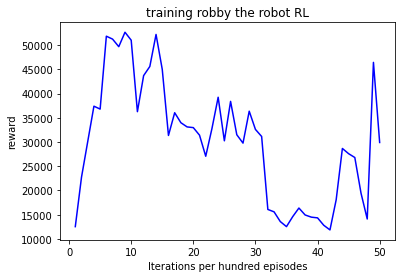

In [157]:
# Training Reward plot
total = 0
cumulative_training_reward = []
for i, reward in enumerate(training_reward):
    total = total + reward[0]
    if(((i+1) % 100) == 0):
        cumulative_training_reward.append(total)
        total = 0
iteration_axis = np.arange(1,len(cumulative_training_reward)+1, dtype=int) # 1 extra iteration to account for initial generation
plt.xlim=(0,cumulative_training_reward)
plt.title("training robby the robot RL") 
plt.xlabel("Iterations per hundred episodes") 
plt.ylabel("reward") 
plt.plot(iteration_axis,cumulative_training_reward,color='b') 
plt.show()

In [158]:
test_reward, tested_Q_Matrix = Q_Learning_Robby(N, M, epsilon, eta, gamma, False, trained_Q_Matrix)

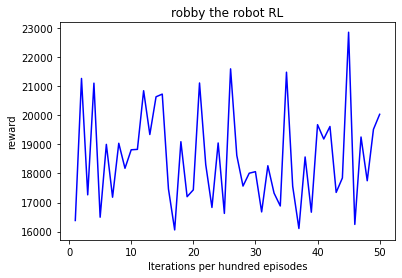

185.3814
159.53294560698114


In [170]:
# Testing Reward plot
# total_reward = np.sum(test_reward)
# Test_Average = total_reward/N
Test_Average = np.mean(test_reward)
Test_Standard_Deviation = np.std(test_reward)
# Test_Standard_Deviation = np.sqrt(1/N)
# Test_Average,Test_Standard_Deviation = [],[]
# for episode, reward in enumerate(test_reward):
#     Test_Average.append(reward/total_reward)
#     Test_Standard_Deviation.append()

total = 0
cumulative_testing_reward = []
for i, reward in enumerate(test_reward):
    total = total + reward[0]
    if(((i+1) % 100) == 0):
        cumulative_testing_reward.append(total)
        total = 0
iteration_axis = np.arange(1,len(cumulative_testing_reward)+1, dtype=int) # 1 extra iteration to account for initial generation
plt.xlim=(0,cumulative_testing_reward)
plt.title("robby the robot RL") 
plt.xlabel("Iterations per hundred episodes") 
plt.ylabel("reward") 
plt.plot(iteration_axis,cumulative_testing_reward,color='b') 
plt.show()
print(Test_Average)
print(Test_Standard_Deviation)

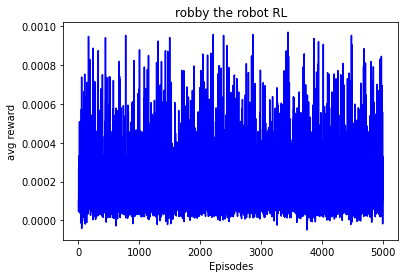

[0.00010033]
[0.00016075]


In [165]:
iteration_axis = np.arange(1,len(test_reward)+1, dtype=int) # 1 extra iteration to account for initial generation
plt.xlim=(0,test_reward)
plt.title("robby the robot RL") 
plt.xlabel("Episodes") 
plt.ylabel("avg reward") 
plt.plot(iteration_axis,Test_Average,color='b') 
plt.show()
print(Test_Average[0])
print(Test_Average[N-1])